# Concurrency

RADICAL-Analytics (RA) offers a method `ra.session.concurrency` that returns a time series, counting the number of tasks which are matching a given pair of timestamps at any point in time. For example, a time series can show the number of concurrent tasks that were scheduled, executed or staging in/out at every point of time, during the execution of the workload.

We plot concurrency time series as a canonical line plot. We can add to the same plot multiple timeseries, showing the relation among diverse components of each RADICAL-Cybertool (RCT) system.

## Prologue

Load the Python modules needed to profile and plot a RCT session.

In [1]:
import os
import tarfile

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import radical.utils as ru
import radical.pilot as rp
import radical.entk as re
import radical.analytics as ra

1664961008.308 : radical.analytics    : 28916 : 140094450898752 : INFO     : radical.analytics    version: 1.16.0-v1.16.0-24-g1ea17a5@fix-rtd_build


Load the RADICAL Matplotlib style to obtain viasually consistent and publishable-qality plots.

In [2]:
plt.style.use(ra.get_mplstyle('radical_mpl'))

Usually, it is useful to record the stack used for the analysis. 

<div class="alert alert-info">

__Note:__ The analysis stack might be different from the stack used to create the session to analyze. Usually, the two stacks must have the same minor release number (Major.Minor.Patch) in order to be compatible.

</div>

In [3]:
! radical-stack

1664961008.812 : radical.analytics    : 28979 : 139873360185152 : INFO     : radical.analytics    version: 1.16.0-v1.16.0-24-g1ea17a5@fix-rtd_build

  python               : /mnt/home/merzky/radical/radical.analytics.devel/ve3/bin/python3
  pythonpath           : 
  version              : 3.8.0
  virtualenv           : /mnt/home/merzky/radical/radical.analytics.devel/ve3

  radical.analytics    : 1.16.0-v1.16.0-24-g1ea17a5@fix-rtd_build
  radical.entk         : 1.16.0-v1.16.0@master
  radical.gtod         : 1.13.0
  radical.pilot        : 1.17.0-v1.17.0-148-g5a63a7f8e@devel
  radical.saga         : 1.17.0-v1.17.0-2-g5b9803bb@devel
  radical.utils        : 1.17.0-v1.17.0-4-ge3c8acb@fix-docs



## Session

Name and location of the session we profile.

In [4]:
sid = 'rp.session.rivendell.merzky.019270.0000'
sdir = 'sessions/'

Unbzip and untar the session.

In [5]:
sp = sdir + sid + '.tar.bz2'
tar = tarfile.open(sp, mode='r:bz2')
tar.extractall(path=sdir)
tar.close()

Create a ``ra.Session`` object for the session. We do not need EnTK-specific traces so load only the RP traces contained in the EnTK session. Thus, we pass the ``'radical.pilot'`` session type to ``ra.Session``.

<div class="alert alert-warning">
    
__Warning:__ We already know we need information about pilots and tasks. Thus, we save in memory two session objects filtered for pilots and tasks. This might be too expensive with large sessions, depending on the amount of memory available.

</div>
    
<div class="alert alert-info">
    
__Note:__ We save the ouput of ``ra.Session`` in ``capt`` to avoid polluting the notebook with warning messages. 

</div>

In [6]:
# %%capture capt

sp = sdir + sid

session = ra.Session(sp, 'radical.pilot')
pilots  = session.filter(etype='pilot', inplace=False)
tasks   = session.filter(etype='task' , inplace=False)

## Plotting

We name some pairs of events we want to use for concurrency analysis. We use the ra.session's concurrency method to compute the number of tasks which match the given pair of timestamps at every point in time. We zero the time of the X axes.

In [7]:
pairs = {'Task Scheduling'  : [{ru.STATE: 'AGENT_SCHEDULING'},
                               {ru.EVENT: 'schedule_ok'     } ],
         'Task Execution'   : [{ru.EVENT: 'rank_start'      },
                               {ru.EVENT: 'rank_stop'       } ]}

time_series = {pair: session.concurrency(event=pairs[pair]) for pair in pairs}

Text(0.5, 0, 'Time (s)')

findfont: Font family ['[DeJavu serif]'] not found. Falling back to DejaVu Sans.


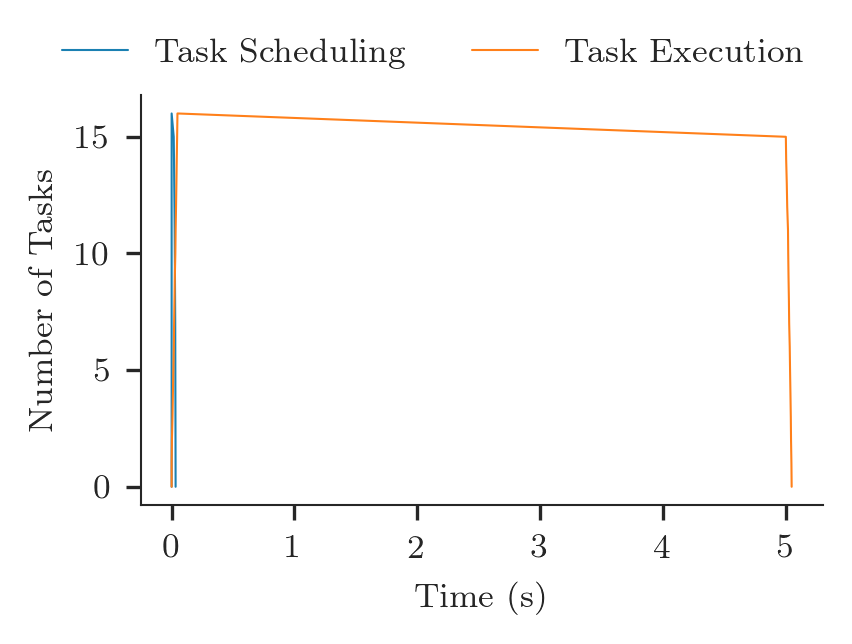

In [8]:
fig, ax = plt.subplots(figsize=(ra.get_plotsize(212)))

for name in time_series:

    zero = min([e[0] for e in time_series[name]])
    x = [e[0]-zero for e in time_series[name]]
    
    y = [e[1] for e in time_series[name]]
    ax.plot(x, y, label=ra.to_latex(name))
    
ax.legend(ncol=2, loc='upper left', bbox_to_anchor=(-0.15,1.2))
ax.set_ylabel('Number of Tasks')
ax.set_xlabel('Time (s)')

The plot above shows that 40 tasks are between 'AGENT_SCHEDULING' and 'schedule_ok' at the beginning of the execution (dark blue). Few seconds later, 20 tasks are between 'rank_start' and 'rank_stop', i.e., they are scheduled and start executing. The first 20 tasks appear to have a relatively uniform duration of ~90s. This is consistent with the task runtime distribution measured in [duration analysis](duration.ipynb#Distribution-of-Durations). 

When the first 20 tasks start to terminate their execution (i.e., they fire the 'rank_stop' event), the second "generation" of 20 tasks enter between 'rank_start' and 'rank_stop', i.e., they are scheduled and start executing. At ~110s, all the tasks have been scheduled so no task remain between 'AGENT_SCHEDULING' and 'schedule_ok'. Conistently, the Task Scheduling line decreases and then disappears. 

At ~170s also the tasks of the second generation start to terminate their execution. Accordingly, the number of executing tasks decreases, as shown by the Task Execution line. At ~190s, execution terminates and no lines are visible.